#  Practical assessment for Business Intelligence Analyst

##  Problem Setting
- You are supporting an e-commerce platform
- Currently, the decision making at this company is not
very data-informed
- They do not own a data warehouse and do not have automated reports
- You are able to access backend data about customers and orders

## Task
In 2 weeks time the CEO of the company has to present to investment board members how the company is currently doing. While preparing his presentation, he assumes the following:
- The company is growing in terms of customers and conversions and growth is healthy.
- The company should invest more in Offline sales, which look promising.
- There are certain customer segments that behave significantly different than others.

He wants you to analyze and make sense of the given data to help him support/disagree with his assumptions.

##  Resources

### customers.csv

| column | content |
|---|---|
| customer_id | an identifier for the customer |
| first_order_day | the date, when the customer ordered the first time |
| customer_type | B2B or B2C |
| primary_sales_channel | offline or online |

### orders.csv

| column | content |
|---|---|
| order_id | an identifier for the order |
| customer_id | an identifier for the customer |
| order_date | date when the order was placed |
| revenue | revenue in EUR that is generated by this order |



### monthly_revenue_2016.csv
This csv contains historical data for the monthly revenue in 2016 that was aggregated by a former data analyst


## 1. data import, cleaning and wrangling

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm

In [2]:
path = "data/"

customers = pd.read_csv(path+"customers.csv")
orders = pd.read_csv(path+"orders.csv")
monthly_revenue = pd.read_csv(path+"monthly_revenue_2016.csv")

### customers

In [3]:
customers.head()

,customer_id,customer_type,primary_sales_channel,first_order_day_fk
0,K0100097,B2C,Offline,20170117
1,K0100437,B2C,Offline,20170118
2,K0100451,B2C,Offline,20170118
3,K0100585,B2C,Offline,20170119
4,K0100681,B2C,Offline,20170120


In [4]:
print(customers.shape)
print(customers.dtypes)

(11628, 4)
customer_id              object
customer_type            object
primary_sales_channel    object
first_order_day_fk        int64
dtype: object


In [5]:
customers["customer_type"].value_counts()/len(customers)

B2C    0.995872
B2B    0.004128
Name: customer_type, dtype: float64

In [6]:
customers["primary_sales_channel"].value_counts()/len(customers)

Online     0.868163
Offline    0.131837
Name: primary_sales_channel, dtype: float64

In [7]:
customers["customer_id"].nunique()

11628

In [8]:
customers.isna().sum()

customer_id              0
customer_type            0
primary_sales_channel    0
first_order_day_fk       0
dtype: int64

- unique customers id (same unique values as dataset length)
- 2 types of customers, 99,5% B2C
- 2 types of channels, almost 87% online
- no NaN
- we need to work with the date format

In [9]:
# transform format into date
customers["date_first_order"] = pd.to_datetime(customers["first_order_day_fk"], format="%Y%m%d")

In [10]:
# drop column
customers = customers.drop(columns=["first_order_day_fk"])

In [11]:
customers.describe().T

,count,unique,top,freq,first,last
customer_id,11628,11628,K2439383658,1,NaT,NaT
customer_type,11628,2,B2C,11580,NaT,NaT
primary_sales_channel,11628,2,Online,10095,NaT,NaT
date_first_order,11628,786,2017-01-08 00:00:00,118,2014-09-03,2017-06-30


### orders

In [12]:
orders

,order_id,customer_id,order_date_fk,revenue
0,96149,K4078373803.0,20170101,128.70
1,281101,K3929324291.0,20170101,125.33
2,96244,K1706191515.0,20170101,118.09
3,96162,K4291564253.0,20170101,80.80
4,96204,K3541486465.0,20170101,75.80
...,...,...,...,...
24061,291614,K424139434.0,20170630,12.97
24062,303595,K2958888446.0,20170630,11.98
24063,293138,K708187630.0,20170630,11.98
24064,298788,K3477419091.0,20170630,11.89


In [13]:
orders.dtypes

order_id           int64
customer_id       object
order_date_fk      int64
revenue          float64
dtype: object

- order_id doesn't refer to a number, therefore should be object
- change order_date_fk format
- customer_id has a ".0" at the end, remove use the same type as in the customer dataset


In [14]:
# transform object
orders["order_id"] = orders["order_id"].astype("object")

In [15]:
orders["order_date"] = pd.to_datetime(orders["order_date_fk"], format="%Y%m%d")
# drop column
orders = orders.drop(columns=["order_date_fk"])

In [16]:
orders["customer_id"] = orders["customer_id"].str[:-2]

In [17]:
orders

,order_id,customer_id,revenue,order_date
0,96149,K4078373803,128.70,2017-01-01
1,281101,K3929324291,125.33,2017-01-01
2,96244,K1706191515,118.09,2017-01-01
3,96162,K4291564253,80.80,2017-01-01
4,96204,K3541486465,75.80,2017-01-01
...,...,...,...,...
24061,291614,K424139434,12.97,2017-06-30
24062,303595,K2958888446,11.98,2017-06-30
24063,293138,K708187630,11.98,2017-06-30
24064,298788,K3477419091,11.89,2017-06-30


### monthly revenue

In [18]:
# add year to monthly revenue
monthly_revenue["year"] = "2016" + " " + monthly_revenue["month"]
# convert into date (attributed to first day of the month)
monthly_revenue["date"] = pd.to_datetime(monthly_revenue["year"])
# drop columns "month" & "year"
monthly_revenue = monthly_revenue.drop(columns=["month","year"])

In [19]:
# add year-month to orders
orders["month"] = pd.DatetimeIndex(orders["order_date"]).month
orders["year"] = pd.DatetimeIndex(orders["order_date"]).year
orders["year_month"] = pd.to_datetime(orders["year"].astype(str)+"-"+orders["month"].astype(str))

In [20]:
# group by month
monthly_revenue_2017 = orders.groupby(["year_month"]).sum()["revenue"]
monthly_revenue_2017 = monthly_revenue_2017.to_frame().reset_index()

In [21]:
# re-arrange monthly_revenue_2017
monthly_revenue_2017 = monthly_revenue_2017[["year_month","revenue"]]

In [22]:
# re-arrange monthly_revenue
monthly_revenue["revenue"] = monthly_revenue["revenue(EUR)"]
monthly_revenue["year_month"] = monthly_revenue["date"]
monthly_revenue_2016 = monthly_revenue[["year_month","revenue"]]

In [23]:
# concat revenue 2016 & 2017
monthly_revenue = pd.concat([monthly_revenue_2016, monthly_revenue_2017]).reset_index(drop=True)
monthly_revenue

,year_month,revenue
0,2016-01-01,223803.40
1,2016-02-01,152010.60
2,2016-03-01,207492.59
3,2016-04-01,198400.37
4,2016-05-01,172665.00
5,2016-06-01,92489.00
6,2016-07-01,88955.01
7,2016-08-01,154239.94
8,2016-09-01,175366.28
9,2016-10-01,194802.03


### monthly orders

In [24]:
monthly_orders = orders.groupby(by=["year_month"]).agg(["count", "sum","mean"])["revenue"].reset_index()
monthly_orders

,year_month,count,sum,mean
0,2017-01-01,6462,295974.75,45.802344
1,2017-02-01,3699,211228.35,57.104177
2,2017-03-01,3604,679477.52,188.534273
3,2017-04-01,3851,261289.01,67.849652
4,2017-05-01,4119,229030.20,55.603350
5,2017-06-01,2331,134431.25,57.671064


# Questions
## 1. The company is growing in terms of customers and conversions and growth is healthy

break down this questions in 3 parts: 

##### 1.1 the amount of (new) customers is increasing

##### 1.2 the amount conversions is increasing
we need to define "conversions" in this context, not clearly defined in my understanding.
I can infer 2 metrics:
- average value per order
- average orders per customer

##### 1.3 the growth is healthy
the assumption here is that the growth is healthy if there is a positive trend in the growth of revenue in general

### 1.1 the amount of (new) customers is increasing

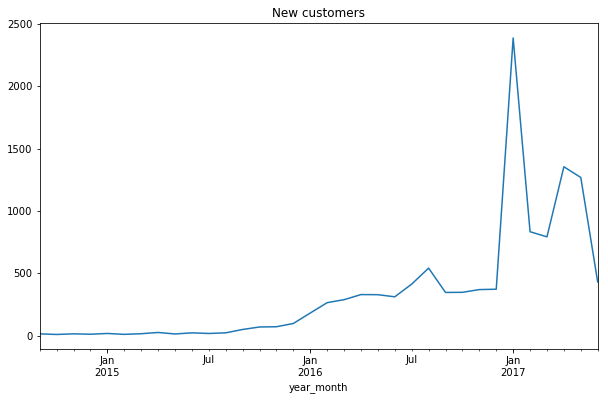

In [25]:
customers["year_month"] = pd.to_datetime(customers["date_first_order"]).dt.to_period("M").astype(str)

customers["year_month"] = pd.to_datetime(customers["year_month"])

# plot line
fig, ax = plt.subplots(figsize=(10,6))
customers.groupby(["year_month"]).count()["customer_id"].plot().title.set_text("New customers");

Overall, customers are increasing. Knowing the distinction between B2B and B2C, inspect in detail

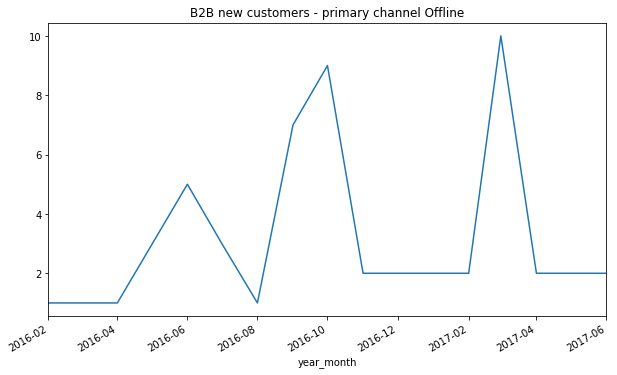

In [26]:
fig, ax = plt.subplots(figsize=(10,6))
# B2B there are only Offline as primary channel
(customers[customers["customer_type"].eq("B2B")]
          .groupby(["year_month"])                              
          .count()["customer_id"]     
          .plot()     
          .title.set_text("B2B new customers - primary channel Offline"))

B2B customers are very small in amount to be consider overall the growth in customers. Maybe valuable in terms of orders and revenue (inspect later), but not significant in terms of number of customers

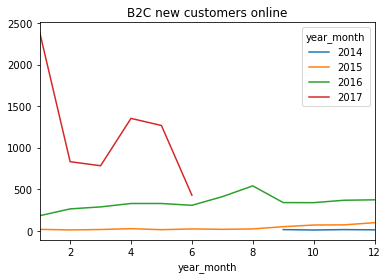

In [27]:
# aggregate monthly new customers b2c
new_b2c_customers_monthly = ((customers[customers["customer_type"].eq("B2C")]
                                .groupby(["year_month"])                              
                                .count()[["customer_id"]])
                                .reset_index()
                                .rename(columns={"customer_id":"new_customers_b2c"}))


# compare Year over Year
pd.pivot_table(new_b2c_customers_monthly,
               index=pd.DatetimeIndex(new_b2c_customers_monthly["year_month"]).month,
               columns=pd.DatetimeIndex(new_b2c_customers_monthly["year_month"]).year,
               values="new_customers_b2c").plot().title.set_text("B2C new customers online");

Year over year, we see a steady increase, but in 2017, the pattern changed significantly, having an extraordinary peak in January (also April&May), with a strong decrease in June

#### Overall the customers are growing, but it is necessary to monitor the decrease in June 2017 as a "hangover" of the peak in the previous months or as a change of trend

### 1.2 The amount of conversions is increasing

As mentioned before, here the problematic aspect is to define what is "conversion"

In [28]:
# calculate avg value per order

In [29]:
# calculate amount of orders per customer

### 1.3 Growth is healthy
the assumption here is that the growth is healthy if there is a positive trend in the growth of revenue in general

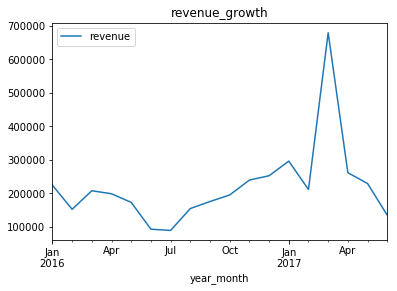

In [30]:
monthly_revenue.set_index("year_month").plot().title.set_text("revenue_growth");

intuitively we can infer a positive trend, but declining in the last months, for a better understanding:
- calculate the linear regression for the period of 18 months (data available)
- compare growth YoY in the first semesters 2016 & 2017 (data available)

In [31]:
# prepare data for fitted line

# create time variable
monthly_revenue_lr = monthly_revenue.assign(t=monthly_revenue.index+1)

# create constant
monthly_revenue_lr = monthly_revenue_lr.assign(constant=1)

monthly_revenue_lr = monthly_revenue_lr.set_index("year_month")

In [32]:
# run linear regression
rev_train = monthly_revenue_lr.loc["2016-01-01":"2017-06-01"]

# create variables
y = rev_train["revenue"]
X = rev_train[["constant", "t"]]
lin_reg = sm.OLS(y, X)
results = lin_reg.fit()

In [33]:
results.summary()

/Users/ivanlopezlobato/miniconda3/envs/code_red/lib/python3.7/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     2.498
Date:                Sun, 28 Jun 2020   Prob (F-statistic):              0.134
Time:                        19:36:03   Log-Likelihood:                -235.29
No. Observations:                  18   AIC:                             474.6
Df Residuals:                      16   BIC:                             476.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant    1.369e+05      6e+04      2.282      0.036    9751.434    2.64e+05
t           8761.3767   5543.040      1.581      0.134   -2989.343    2.05e+04
==============================================================================
Omnibus:                       27.382   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.428
Skew:                           2.310   Prob(JB):                     8.28e-11
Kurtosis:                       9.369   Cond. No.                         22.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
results.params

constant    136945.397778
t             8761.376667
dtype: float64

In [35]:
# make a copy
monthly_revenue_pred = monthly_revenue_lr.copy()

# assign values of linear regression to plot
monthly_revenue_pred = monthly_revenue_pred.assign(predicted_revenue=(results.params["constant"] + monthly_revenue_pred["t"] * results.params["t"]))

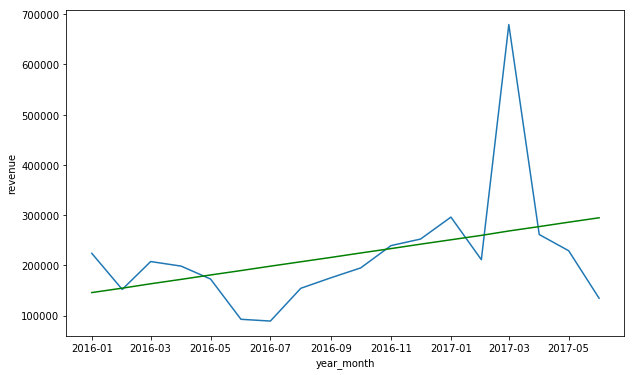

In [36]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(data=monthly_revenue_pred.loc["2016-01-01":"2017-06-01"],
             x=monthly_revenue_pred.loc["2016-01-01":"2017-06-01"].index,
             y="revenue",
             ax=ax);
ax.plot(monthly_revenue_pred.loc["2016-01-01":"2017-06-01", "predicted_revenue"], color="green");

We observe that the trend (linear regression) of the values along 18 months is ascending in regards of the revenue, so we can state that we are "healthy" growing
However, we can detect an unexpected peak in March 2017, that might be the main cause the growth.

to check in detail, we visualize growth YoY

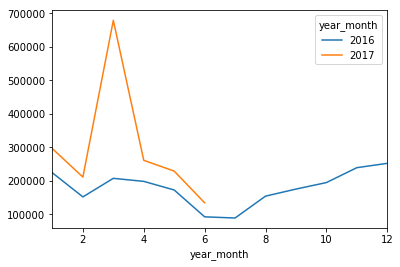

In [37]:
# compare Year over Year
pd.pivot_table(monthly_revenue,
               index=pd.DatetimeIndex(monthly_revenue["year_month"]).month,
               columns=pd.DatetimeIndex(monthly_revenue["year_month"]).year,
               values="revenue").plot();

Visually we can infere a seasonal behaviour, with a growth YoY

to observe more in detail, we calculate the actual growth YoY in %

In [38]:
monthly_revenue_yoy = (pd.pivot_table(monthly_revenue,
                                     index=pd.DatetimeIndex(monthly_revenue["year_month"]).month,
                                     columns=pd.DatetimeIndex(monthly_revenue["year_month"]).year,
                                     values="revenue")
                        .rename_axis(None, axis=1))

monthly_revenue_yoy["growth"] = (monthly_revenue_yoy[2017]-monthly_revenue_yoy[2016])/monthly_revenue_yoy[2016]

monthly_revenue_yoy[:6][["growth"]]

,growth
year_month,
1,0.322477
2,0.389563
3,2.274707
4,0.316978
5,0.326443
6,0.453484


we can check that the percentual growth YoY in the first 6 months of 2017 is steady, always positive in a range of (31-45%), with the additional push on March of a 227% growth in comparison to the same period of 2016

in general, revenue growth seems healthy (the peak on March would need further inspection), with seasonal fluctiations

## 2. The company should invest more in Offline sales, which look promising.

in which sense is "promising"?

in 2017 it is opened this new line of customers with offline as primary channel
- inspect volume of offline vs online (new customers & revenue), **only for B2C**

B2B customers are all Offline, and it is assumed that the different behavior is due the nature of the type over the primary channel 

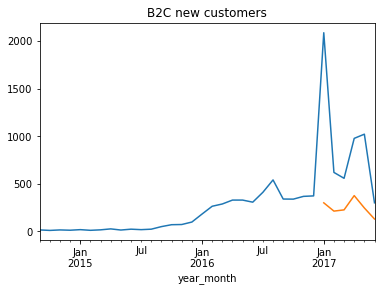

In [39]:
(customers[customers["customer_type"].eq("B2C")&customers["primary_sales_channel"].eq("Online")]
          .groupby(["year_month"])                              
          .count()["customer_id"]     
          .plot()     
          .title.set_text("B2C new customers"))
(customers[customers["customer_type"].eq("B2C")&customers["primary_sales_channel"].eq("Offline")]
          .groupby(["year_month"])                              
          .count()["customer_id"]     
          .plot());

In [40]:
b2c_online_2017 = (customers[customers["customer_type"].eq("B2C")&customers["primary_sales_channel"].eq("Online")&customers["year_month"].ge("2017-01")]
                  .groupby(["year_month"])                              
                  .count()["customer_id"]).sum()

b2c_offline_2017 = (customers[customers["customer_type"].eq("B2C")&customers["primary_sales_channel"].eq("Offline")&customers["year_month"].ge("2017-01")]
                  .groupby(["year_month"])                              
                  .count()["customer_id"]).sum()

print("percent of new customers B2C with offline as primary channel in 2017:")
round((b2c_offline_2017 / (b2c_online_2017+b2c_offline_2017))*100,2)


percent of new customers B2C with offline as primary channel in 2017:


21.08

21% of the new b2c customers are offline. if this confirms that open a new source of customers not reached before by online media, it is definitely promising

but let's look a step further how this become into revenue

In [41]:
orders_enriched = (pd.merge(left=orders, right=customers, how="left", left_on="customer_id", right_on="customer_id")
                   .drop(columns=["year_month_y"])
                   .rename(columns={"year_month_x":"year_month"}))

orders_enriched.head()

,order_id,customer_id,revenue,order_date,month,year,year_month,customer_type,primary_sales_channel,date_first_order
0,96149,K4078373803,128.70,2017-01-01,1,2017,2017-01-01,B2C,Online,2016-05-06
1,281101,K3929324291,125.33,2017-01-01,1,2017,2017-01-01,B2C,Online,2016-07-27
2,96244,K1706191515,118.09,2017-01-01,1,2017,2017-01-01,B2C,Online,2015-07-18
3,96162,K4291564253,80.80,2017-01-01,1,2017,2017-01-01,B2C,Online,2016-09-27
4,96204,K3541486465,75.80,2017-01-01,1,2017,2017-01-01,B2C,Online,2016-10-04


In [42]:
# calculate revenue b2c offline vs online in 2017 (volume of orders and avg value order)

### 3. There are certain customer segments that behave significantly different than others

In [43]:
# b2b vs b2c

In [44]:
# scatterplot orders revenue

In [45]:
# clustering customers (if possible)